In [ ]:
!pip install wandb

In [1]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series/notebook/03_Deeplearning_models")

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import wandb
import bidirectional_lstm as bl
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

In [4]:
with open('../../data/pv_forecast.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [7]:
x_scaler = MinMaxScaler()
x_scaler.fit(pv[['dwpt', 'rhum', 'wspd', 'pres']])
pv[['dwpt', 'rhum', 'wspd', 'pres']] = x_scaler.transform(pv[['dwpt', 'rhum', 'wspd', 'pres']])

In [8]:
pv = pv.set_index('datetime')

In [9]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,12,20,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,14,00,tzinfo=tz):]

# data loader

- torch 에서 LSTM 의 경우 
  - input: (seq_len, batch, input_size)
  - output: (seq_len, batch, num_directions * hidden_size) 

In [10]:
# "train_batch_size": 16,
# "test_batch_size": 4,
# "input_length": 24,
# "stride": 24

In [11]:
iw = 24
ow = iw
num_feature = 5

train_dataset = bl.windowDataset(pv_train[['power_scale', 'dwpt', 'rhum', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)
test_dataset = bl.windowDataset(pv_test[['power_scale', 'dwpt', 'rhum', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)

train_loader = DataLoader(train_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=4)

# train

In [14]:
wandb.init(name='grad_clipping', project="bidirectional_LSTM", entity="yyyyyjkim")

In [15]:
wandb.config = {
    "learning_rate": 0.001,
    "epochs": 500,
    "hidden_size": 30,
    "input_size": 5
}

In [16]:
device='cuda'
model = bl.lstm(input_size=wandb.config["input_size"], hidden_size=wandb.config["hidden_size"], num_layers=1).to(device)

In [18]:
import torch
max_norm = 1
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

tensor(0.)

In [19]:
learning_rate=wandb.config["learning_rate"]
epoch = wandb.config["epochs"]
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [20]:
wandb.watch(model, log='all', log_freq=10)

pbar = tqdm(range(wandb.config['epochs']))
for epoch in pbar:
    pred, true, train_loss = bl.train(model, train_loader, optimizer, criterion, device)
    pred, true, test_loss = bl.predict(model, test_loader, criterion, device)
    wandb.log({"train_loss": train_loss, "test_loss": test_loss})

    pbar.set_postfix(loss=f"train_loss: {train_loss:.5f}")

  0%|          | 0/500 [00:00<?, ?it/s]

In [21]:
wandb.finish()

test_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▃▂▂▁▁▁▂▃▂▂▂▁▂▂▃▁▂▂▁▁▁
train_loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,0.0092
train_loss,0.00458


In [22]:
pred = power_scaler.inverse_transform(pred.reshape(-1,1))
real = power_scaler.inverse_transform(true.reshape(-1,1))

In [23]:
pv_test = pv.loc[datetime(2006,12,15,00,tzinfo=tz):]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


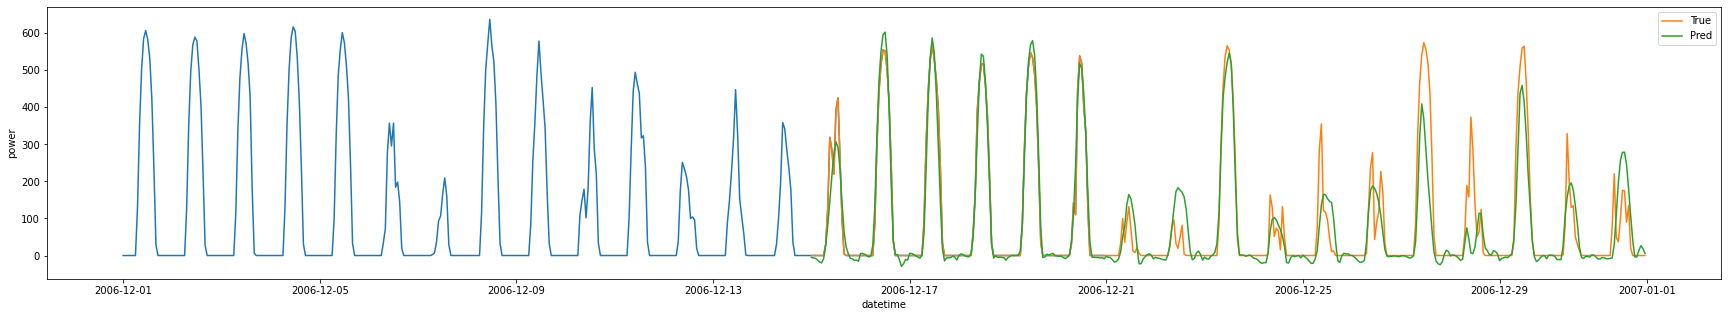

In [24]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, real.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()